# Text Classification in Cross-Validation using Long Short-Term Memory

## Import Libraries

In [1]:
import re
import time
import torch
import random
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from lime import lime_text
from torch import nn, optim
from sklearn import metrics
from string import punctuation
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Set Hyparameters

### Dataset Language Setting

In [2]:
language="italian"

language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"

### Model Parameters

In [3]:
batch_size = 128
dropout_pc = 0.5
n_epochs = 100
patience=5
hidden_dim=50
lr = 1e-3
num_layers=1
bidirectional=True

nfold=10

### Dataset Parameters

In [4]:
path_db="../input/politica/politica.xlsx"
df = pd.read_excel(path_db, sheet_name="Foglio1")

text="testo"
review="cap_maj_master"

n_top_class=35

## Enable GPU

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2019
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

## Load Dataset

In [6]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

output_dim = len(np.unique(classes))

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


## Class Distribution Diagram

Number of Classes found:  21


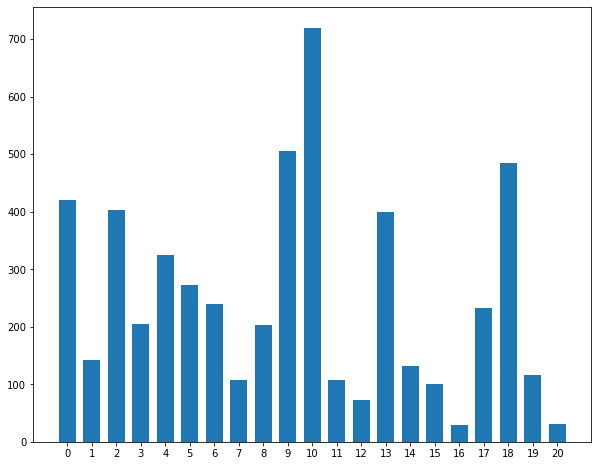

In [7]:
y = np.bincount(classes)
x = np.arange(len(y))
print("Number of Classes found: ", len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


## Define Preprocessor

In [8]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence
    
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

In [9]:
documents, vocab = split_words_documents(documents)

## Preprocessed Dataset Statistics

In [10]:
print("Max sequence length: ", np.max([len(x) for x in documents]))
print("Average sequence length: ",np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print("Quantile sequence length: ",quant)

Max sequence length:  1375
Average sequence length:  201.02611015818562
Quantile sequence length:  248.0


## Vocabulary Build

In [11]:
vocaboli=set(line.strip() for line in open('../input/politica-p/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [12]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

## Define Padding

In [13]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [14]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

## Pretrained Vector Loader

In [15]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [16]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:45, 18977.63it/s]


There are 135327 / 279895 pretrained vectors found.


## Utility Functions

In [17]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

### DataLoader Function

In [18]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

### Plot Function

In [19]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### EarlyStopping Function

In [20]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model

In [21]:
class ClassificationRNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                freeze_embedding=False,
                 n_vocab=None,
                 hidden_dim=100,
                 output_dim=13,
                 dropout = 0.8,
                 pad_idx=0.0,
                 num_layers=2,
                bidirectional=True):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(self.n_embed, 
                           hidden_dim,
                           num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=0 if num_layers < 2 else dropout,
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

        
        
    def forward(self, text, text_length):
        h_embedding = self.dropout(self.embedding(text))
        packed = torch.nn.utils.rnn.pack_padded_sequence(h_embedding, text_length,batch_first=True, enforce_sorted=False)
        h_lstm, (h,c) = self.rnn(packed)
        h_lstm, output_lengths = nn.utils.rnn.pad_packed_sequence(h_lstm,batch_first=True)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        
        out=self.fc1(conc)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

## Evaluate Function

In [22]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

## Define Train Function

In [23]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

## Define Predict Function

In [24]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

## Cross-Validation Loop

train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  378.780383  | 301.357321 |   11.25   |   4.01   
Validation loss decreased (inf --> 301.357321).  Saving model ...
   2    |  364.230484  | 295.381465 |   11.25   |   3.82   
Validation loss decreased (301.357321 --> 295.381465).  Saving model ...
   3    |  353.785976  | 286.115800 |   11.25   |   3.82   
Validation loss decreased (295.381465 --> 286.115800).  Saving model ...
   4    |  336.730409  | 278.699182 |   15.94   |   3.87   
Validation loss decreased (286.115800 --> 278.699182).  Saving model ...
   5    |  317.386062  | 268.101733 |   22.81   |   3.82   
Validation loss decreased (278.699182 --> 268.101733).  Saving model ...
   6    |  290.893136  | 256.257656 |   22.81   |   3.81   
Validation loss decreased (268.101733 --> 256.257656).  Saving model ...


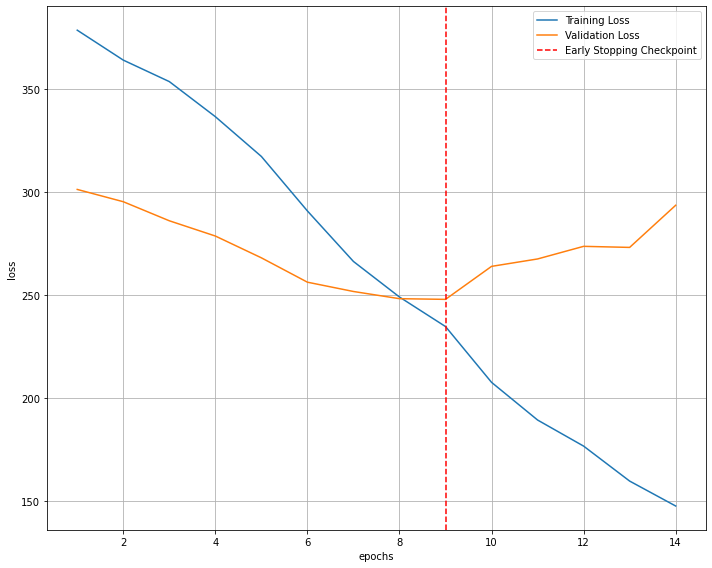

--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.28      0.38      0.32        42
           1       0.00      0.00      0.00        15
           2       0.16      0.68      0.26        40
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        32
           5       0.16      0.22      0.19        27
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        11
           8       0.29      0.10      0.15        20
           9       0.64      0.74      0.69        50
          10       0.58      0.57      0.57        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.17      0.17      0.17        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

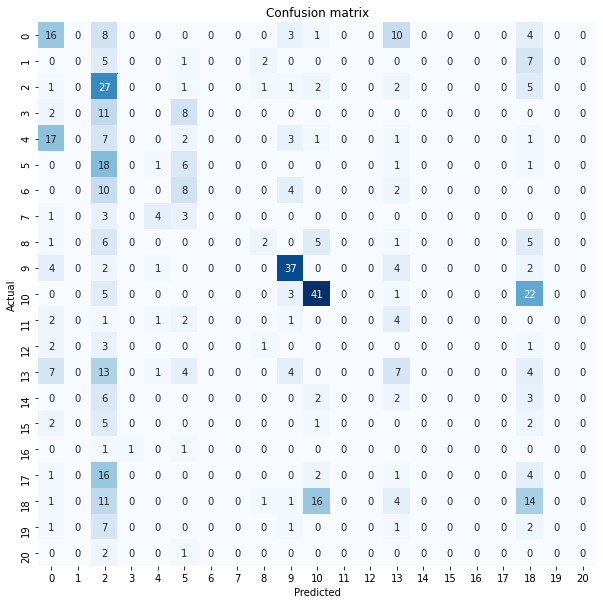


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  378.495270  | 299.896948 |   11.25   |   3.88   
Validation loss decreased (inf --> 299.896948).  Saving model ...
   2    |  364.671518  | 294.435018 |   11.25   |   3.88   
Validation loss decreased (299.896948 --> 294.435018).  Saving model ...
   3    |  355.065920  | 283.993196 |   11.56   |   3.86   
Validation loss decreased (294.435018 --> 283.993196).  Saving model ...
   4    |  341.906286  | 284.210209 |   17.34   |   3.84   
EarlyStopping counter: 1 out of 5
   5    |  326.268856  | 272.730085 |   17.34   |   3.89   
Validation loss decreased (283.993196 --> 272.730085).  Saving model ...
   6    |  310.193032  | 258.805209 |   24.38   |   3.88   
Validation loss decreased (272.730085 --> 258.805209).  Saving model ...
   7    |  288.619200  | 259.076680 | 

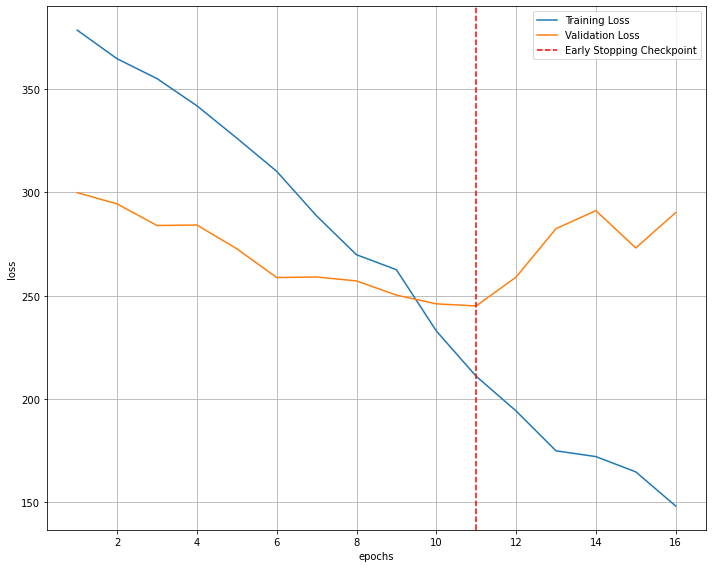

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.21      0.52      0.30        42
           1       0.00      0.00      0.00        15
           2       0.36      0.68      0.47        40
           3       0.44      0.35      0.39        20
           4       0.00      0.00      0.00        33
           5       0.40      0.89      0.55        28
           6       0.75      0.38      0.50        24
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        20
           9       0.67      0.84      0.74        50
          10       0.60      0.75      0.67        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.22      0.10      0.14        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

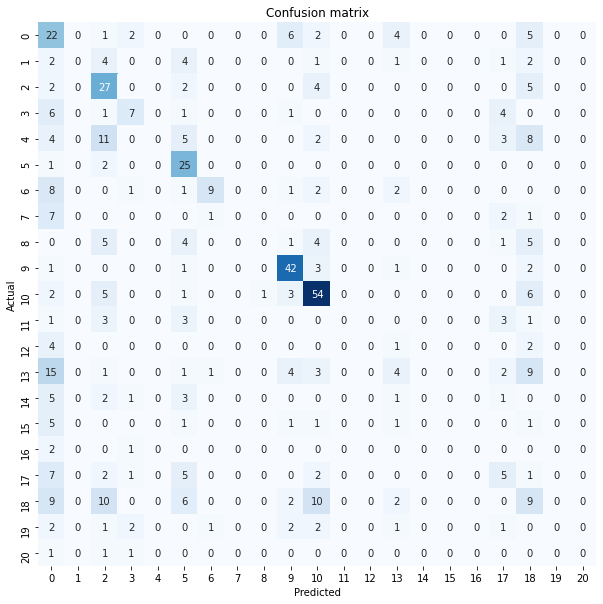


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  374.970399  | 298.953450 |   11.25   |   3.88   
Validation loss decreased (inf --> 298.953450).  Saving model ...
   2    |  363.178570  | 293.305408 |   11.25   |   3.85   
Validation loss decreased (298.953450 --> 293.305408).  Saving model ...
   3    |  353.257196  | 279.913421 |   11.88   |   3.91   
Validation loss decreased (293.305408 --> 279.913421).  Saving model ...
   4    |  335.303952  | 273.168253 |   17.03   |   3.83   
Validation loss decreased (279.913421 --> 273.168253).  Saving model ...
   5    |  322.247567  | 265.053192 |   16.88   |   3.98   
Validation loss decreased (273.168253 --> 265.053192).  Saving model ...
   6    |  306.796382  | 258.796820 |   17.03   |   3.90   
Validation loss decreased (265.053192 --> 258.796820).  Saving model ...

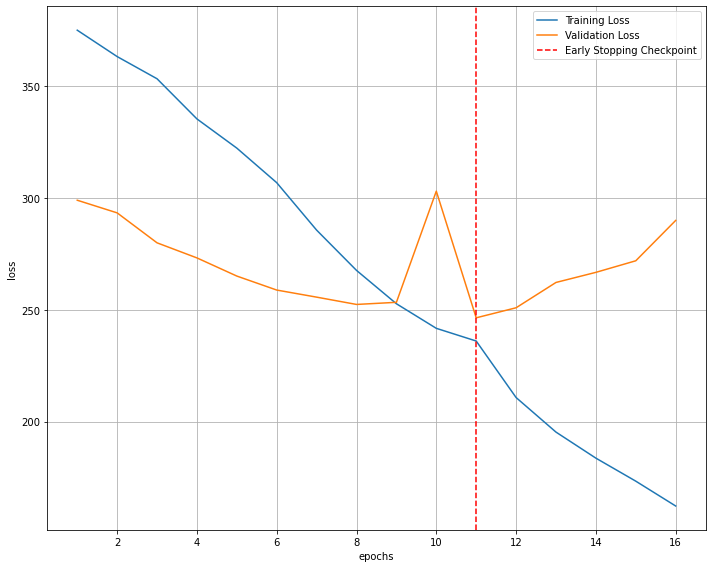

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.27      0.38      0.31        42
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        40
           3       0.67      0.20      0.31        20
           4       0.23      0.48      0.31        33
           5       0.32      0.61      0.42        28
           6       0.11      0.04      0.06        24
           7       0.00      0.00      0.00        11
           8       0.11      0.15      0.12        20
           9       0.74      0.70      0.72        50
          10       0.54      0.82      0.65        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.08      0.12      0.10        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

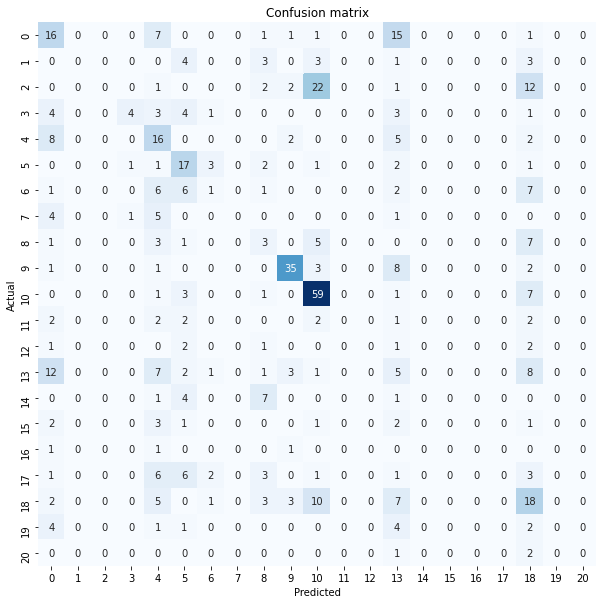


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  379.658699  | 299.366091 |   11.25   |   3.85   
Validation loss decreased (inf --> 299.366091).  Saving model ...
   2    |  365.206175  | 294.074801 |   11.25   |   3.88   
Validation loss decreased (299.366091 --> 294.074801).  Saving model ...
   3    |  356.183313  | 284.140648 |   11.56   |   3.84   
Validation loss decreased (294.074801 --> 284.140648).  Saving model ...
   4    |  336.525574  | 267.636821 |   20.31   |   3.92   
Validation loss decreased (284.140648 --> 267.636821).  Saving model ...
   5    |  308.565222  | 245.599625 |   26.41   |   3.86   
Validation loss decreased (267.636821 --> 245.599625).  Saving model ...
   6    |  281.941217  | 236.314230 |   27.50   |   3.85   
Validation loss decreased (245.599625 --> 236.314230).  Saving model ...

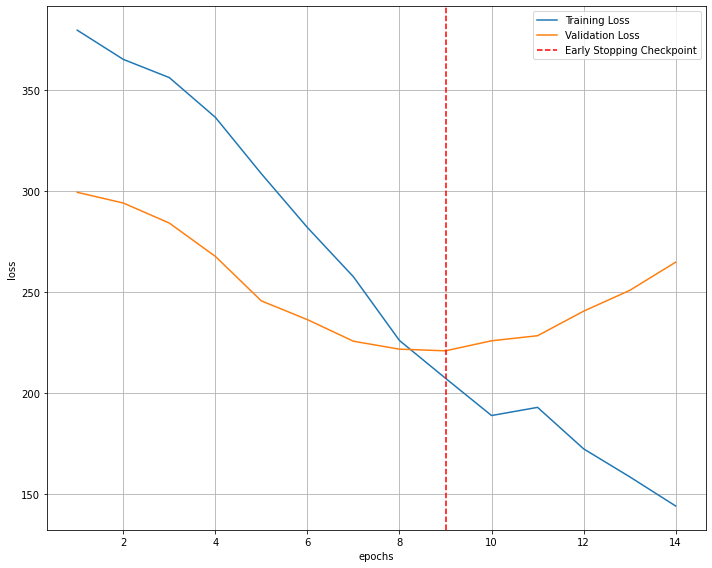

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.34      0.50      0.40        42
           1       0.00      0.00      0.00        14
           2       0.24      0.38      0.29        40
           3       0.19      0.60      0.29        20
           4       0.23      0.33      0.28        33
           5       0.33      0.82      0.47        28
           6       0.10      0.04      0.06        23
           7       0.00      0.00      0.00        11
           8       0.21      0.30      0.25        20
           9       0.84      0.76      0.80        50
          10       0.62      0.78      0.69        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.18      0.05      0.08        40
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

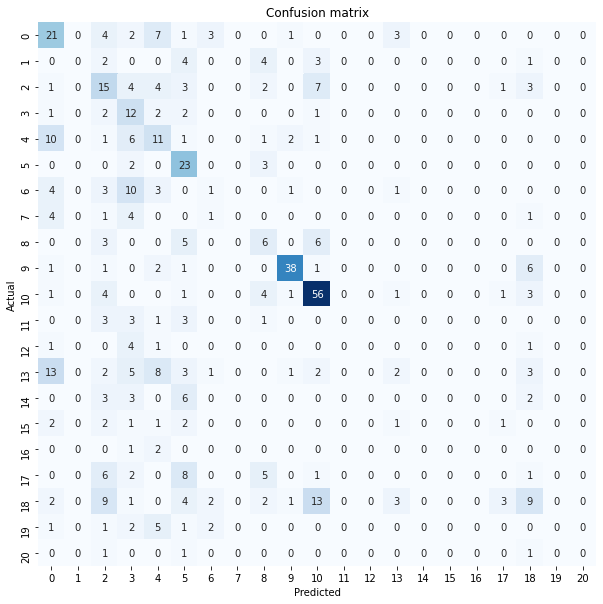


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  375.986588  | 297.847467 |   11.25   |   3.83   
Validation loss decreased (inf --> 297.847467).  Saving model ...
   2    |  363.004290  | 293.160696 |   11.25   |   4.30   
Validation loss decreased (297.847467 --> 293.160696).  Saving model ...
   3    |  354.613943  | 283.089636 |   11.25   |   3.83   
Validation loss decreased (293.160696 --> 283.089636).  Saving model ...
   4    |  334.890833  | 267.640009 |   20.47   |   3.87   
Validation loss decreased (283.089636 --> 267.640009).  Saving model ...
   5    |  306.820295  | 252.932255 |   19.84   |   3.89   
Validation loss decreased (267.640009 --> 252.932255).  Saving model ...
   6    |  277.071439  | 238.402672 |   24.06   |   3.83   
Validation loss decreased (252.932255 --> 238.402672).  Saving model ...

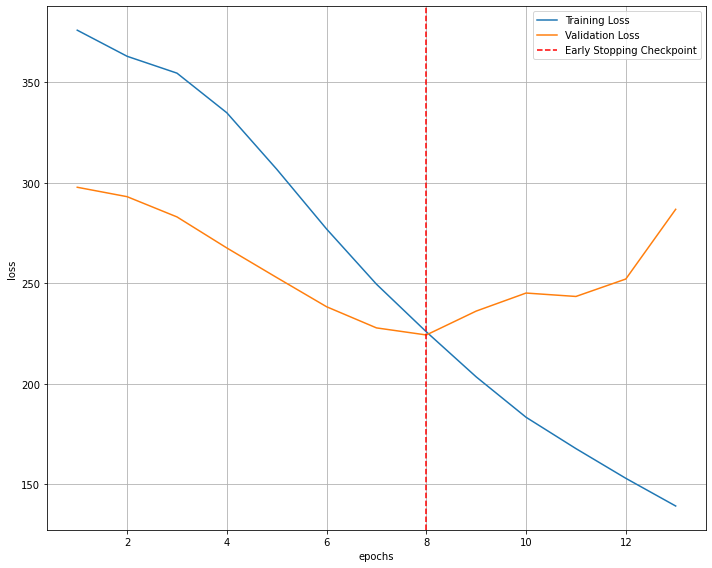

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.31      0.55      0.40        42
           1       0.00      0.00      0.00        14
           2       0.29      0.20      0.24        40
           3       0.22      0.75      0.34        20
           4       1.00      0.03      0.06        33
           5       0.27      0.63      0.38        27
           6       0.19      0.21      0.20        24
           7       0.00      0.00      0.00        11
           8       0.23      0.45      0.30        20
           9       0.66      0.82      0.73        51
          10       0.58      0.74      0.65        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.13      0.07      0.10        40
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

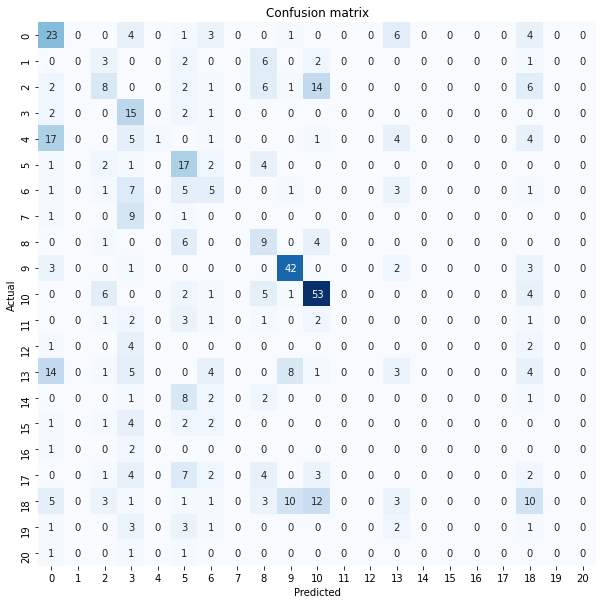


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  377.850746  | 298.414660 |   11.25   |   3.86   
Validation loss decreased (inf --> 298.414660).  Saving model ...
   2    |  361.832393  | 290.237184 |   11.25   |   3.84   
Validation loss decreased (298.414660 --> 290.237184).  Saving model ...
   3    |  344.630784  | 278.554737 |   15.31   |   3.90   
Validation loss decreased (290.237184 --> 278.554737).  Saving model ...
   4    |  334.450306  | 275.542867 |   12.03   |   3.89   
Validation loss decreased (278.554737 --> 275.542867).  Saving model ...
   5    |  322.126125  | 264.387303 |   17.50   |   3.99   
Validation loss decreased (275.542867 --> 264.387303).  Saving model ...
   6    |  306.136608  | 263.331760 |   20.62   |   3.92   
Validation loss decreased (264.387303 --> 263.331760).  Saving model ...

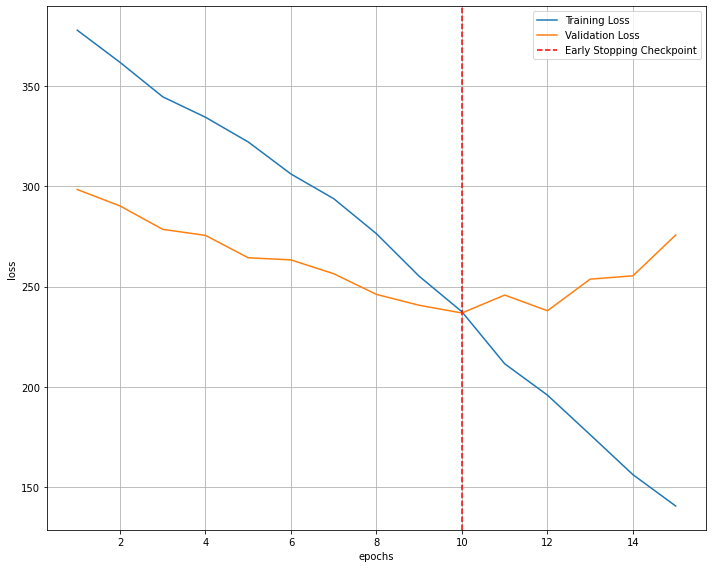

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.13      0.31      0.18        42
           1       0.00      0.00      0.00        14
           2       0.31      0.93      0.47        41
           3       0.25      0.45      0.32        20
           4       0.15      0.22      0.18        32
           5       0.00      0.00      0.00        27
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        21
           9       0.73      0.78      0.75        51
          10       0.75      0.58      0.66        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.20      0.26      0.23        39
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        11
          16       0.00      0.00

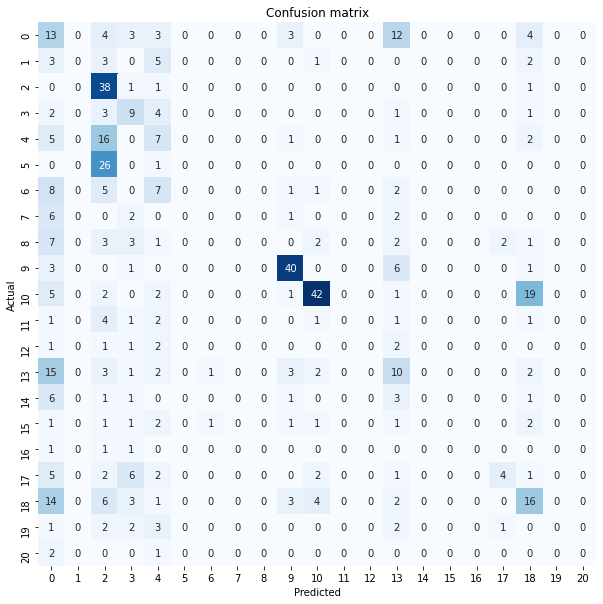


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  377.924930  | 295.615931 |   11.25   |   3.84   
Validation loss decreased (inf --> 295.615931).  Saving model ...
   2    |  363.771018  | 292.425078 |   11.25   |   3.84   
Validation loss decreased (295.615931 --> 292.425078).  Saving model ...
   3    |  354.393303  | 277.362587 |   11.25   |   3.93   
Validation loss decreased (292.425078 --> 277.362587).  Saving model ...
   4    |  335.044166  | 259.691292 |   18.75   |   3.83   
Validation loss decreased (277.362587 --> 259.691292).  Saving model ...
   5    |  309.782872  | 253.312436 |   23.12   |   3.83   
Validation loss decreased (259.691292 --> 253.312436).  Saving model ...
   6    |  293.813381  | 247.393402 |   24.53   |   3.92   
Validation loss decreased (253.312436 --> 247.393402).  Saving model ...

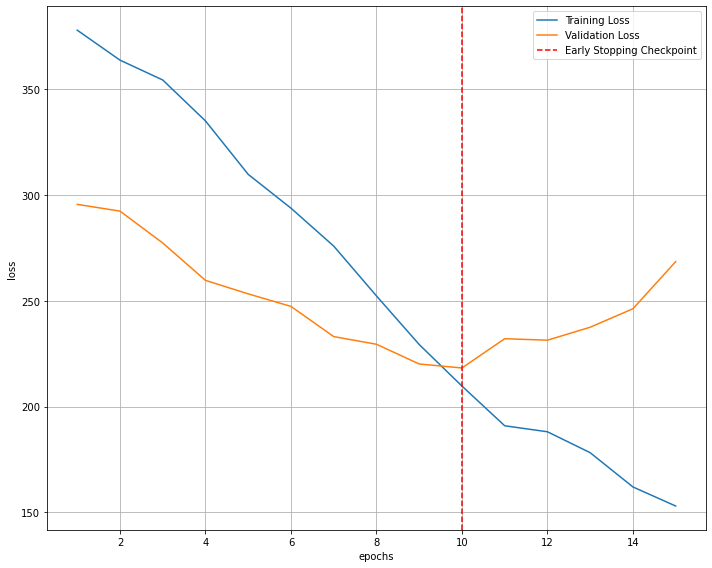

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.49      0.43      0.46        42
           1       0.00      0.00      0.00        14
           2       0.41      0.22      0.29        41
           3       0.00      0.00      0.00        21
           4       0.13      0.28      0.18        32
           5       0.24      0.74      0.37        27
           6       0.16      0.71      0.26        24
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        21
           9       0.68      0.82      0.74        51
          10       0.60      0.72      0.65        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.17      0.03      0.04        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

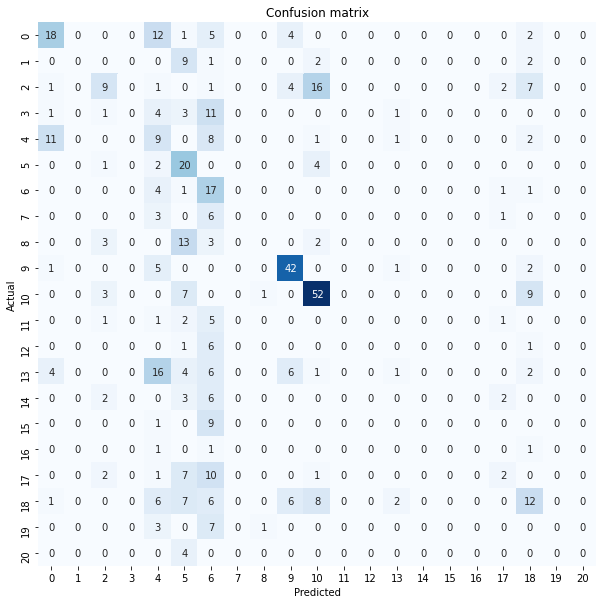


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  377.811174  | 296.699858 |   11.25   |   3.87   
Validation loss decreased (inf --> 296.699858).  Saving model ...
   2    |  364.203947  | 293.360680 |   11.25   |   3.82   
Validation loss decreased (296.699858 --> 293.360680).  Saving model ...
   3    |  356.402592  | 281.164512 |   11.25   |   3.85   
Validation loss decreased (293.360680 --> 281.164512).  Saving model ...
   4    |  336.880008  | 267.986994 |   18.28   |   3.87   
Validation loss decreased (281.164512 --> 267.986994).  Saving model ...
   5    |  308.180556  | 249.991846 |   25.16   |   3.92   
Validation loss decreased (267.986994 --> 249.991846).  Saving model ...
   6    |  288.651505  | 251.039675 |   26.88   |   4.03   
EarlyStopping counter: 1 out of 5
   7    |  276.875011  | 231.271954 | 

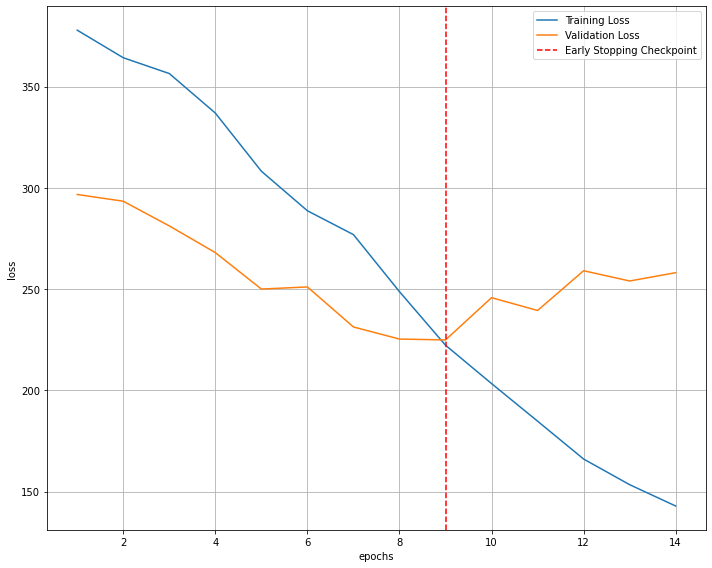

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.25      0.40      0.31        42
           1       0.00      0.00      0.00        14
           2       0.34      0.93      0.49        41
           3       0.29      0.67      0.41        21
           4       0.37      0.53      0.44        32
           5       0.53      0.59      0.56        27
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        21
           9       0.80      0.73      0.76        51
          10       0.71      0.78      0.74        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.21      0.28      0.24        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

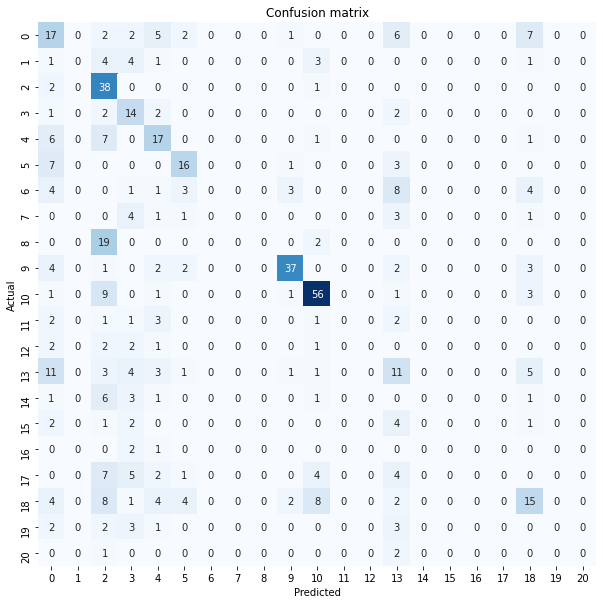


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  375.862445  | 297.413415 |   11.25   |   4.00   
Validation loss decreased (inf --> 297.413415).  Saving model ...
   2    |  363.810324  | 290.932236 |   11.25   |   3.89   
Validation loss decreased (297.413415 --> 290.932236).  Saving model ...
   3    |  351.491116  | 275.439121 |   14.53   |   3.92   
Validation loss decreased (290.932236 --> 275.439121).  Saving model ...
   4    |  335.282250  | 263.124901 |   18.44   |   3.85   
Validation loss decreased (275.439121 --> 263.124901).  Saving model ...
   5    |  318.246159  | 262.252437 |   17.66   |   3.84   
Validation loss decreased (263.124901 --> 262.252437).  Saving model ...
   6    |  316.501866  | 249.901134 |   23.28   |   4.04   
Validation loss decreased (262.252437 --> 249.901134).  Saving model ...

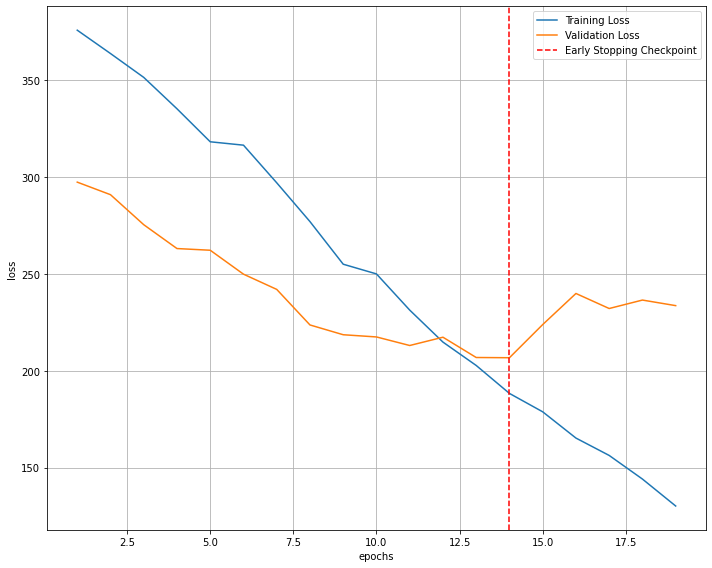

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.22      0.38      0.28        42
           1       0.00      0.00      0.00        14
           2       0.36      0.57      0.44        40
           3       0.27      0.57      0.37        21
           4       0.53      0.56      0.55        32
           5       0.49      0.85      0.62        27
           6       0.33      0.17      0.22        24
           7       0.00      0.00      0.00        10
           8       0.67      0.20      0.31        20
           9       0.86      0.59      0.70        51
          10       0.90      0.49      0.63        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.20      0.55      0.29        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

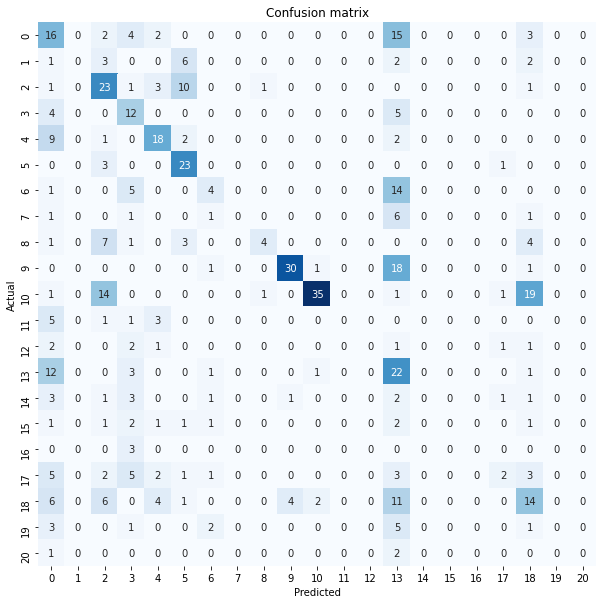


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  379.568907  | 296.519581 |   11.25   |   3.85   
Validation loss decreased (inf --> 296.519581).  Saving model ...
   2    |  364.302521  | 292.378522 |   11.25   |   3.84   
Validation loss decreased (296.519581 --> 292.378522).  Saving model ...
   3    |  352.451481  | 284.549098 |   11.25   |   3.83   
Validation loss decreased (292.378522 --> 284.549098).  Saving model ...
   4    |  341.461287  | 285.319420 |   14.79   |   3.93   
EarlyStopping counter: 1 out of 5
   5    |  330.600538  | 276.843494 |   14.01   |   3.83   
Validation loss decreased (284.549098 --> 276.843494).  Saving model ...
   6    |  317.066872  | 271.224161 |   18.54   |   3.89   
Validation loss decreased (276.843494 --> 271.224161).  Saving model ...
   7    |  296.255959  | 270.478606 | 

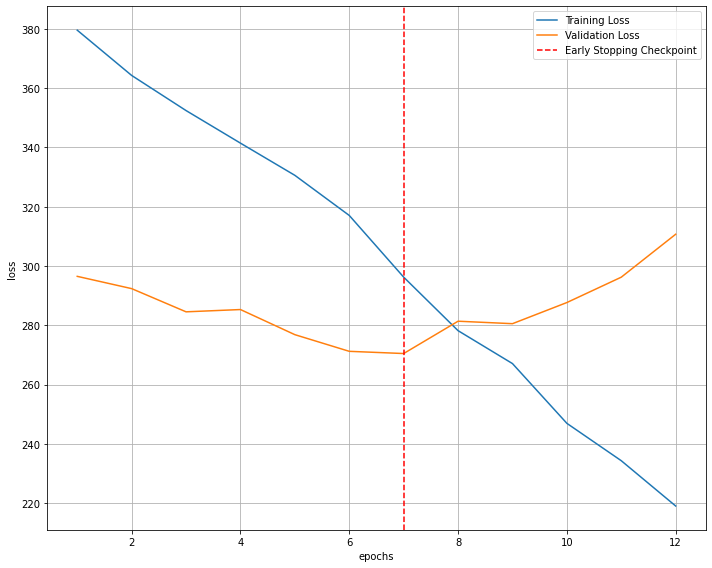

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.11      0.24      0.15        42
           1       0.00      0.00      0.00        15
           2       0.67      0.10      0.17        40
           3       0.33      0.14      0.20        21
           4       0.20      0.53      0.30        32
           5       0.08      0.52      0.14        27
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        50
          10       0.32      0.62      0.43        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

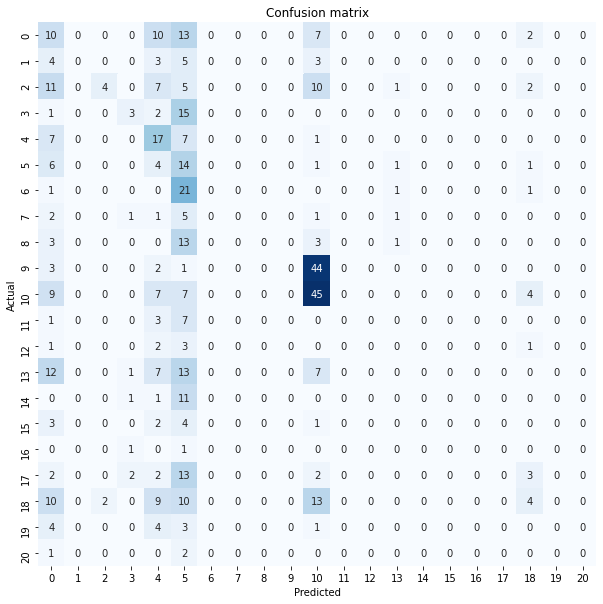

In [25]:
####### Setting up Cross-Validation #####
y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

####### Cross-Validation Loop ############

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    

  ####### Instantiate model ############  
    model = ClassificationRNN(
                        pretrained_embedding=embeddings, 
                        output_dim=output_dim,
                        dropout=dropout_pc,
                        hidden_dim=hidden_dim,
                        num_layers=num_layers,
                        bidirectional=bidirectional
                        )
    
    model=model.double()

    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    ####### Compute Accuracy ##########
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))

    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])

    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break

     ## Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


## Results Output

In [26]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 34.11 +/- 6.28 max: 42.18

CV precision: 29.05 +/- 6.54 max: 41.55

CV recall: 34.11 +/- 6.28 max: 42.18

CV f1: 28.97 +/- 6.46 max: 36.64

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 26.00  +/-10.19  | 40.95 +/- 9.09  | 31.12 +/- 8.95  |   42.00  
   1    | 0.00   +/- 0.00  | 0.00  +/- 0.00  | 0.00  +/- 0.00  |   14.30  
   2    | 31.26  +/-16.31  | 46.73 +/-31.86  | 31.18 +/-14.97  |   40.30  
   3    | 26.63  +/-18.56  | 37.31 +/-26.21  | 26.23 +/-14.20  |   20.50  
   4    | 28.49  +/-28.18  | 29.73 +/-21.70  | 22.79 +/-17.18  |   32.40  
   5    | 28.30  +/-16.11  | 58.77 +/-26.96  | 36.99 +/-19.20  |   27.30  
   6    | 16.37  +/-22.07  | 15.43 +/-21.88  | 12.97 +/-15.60  |   23.90  
   7    | 0.00   +/- 0.00  | 0.00  +/- 0.00  | 0.00  +/- 0.00  |   10.70  
   8    | 14.99  +/-20.24  | 12.00 +/-14.87  | 11.31 +/-12.52  |   20.30  
   9    | 66.16  +/-23.28  |